# Tugas Praktikum 3 DL2021 
> M Naufal Irham R (10818019)




Jawaban ada di bagian akhir dari code

###Persiapan


#### 1.1. Import library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sds

#### 1.2. Menyiapkan dataset 

In [2]:
class PlanarDataset(object):
    def __init__(self, points_per_class):
        self.N = points_per_class

    def load_dataset(self, shape):
        X, Y = getattr(self, "get_"+shape)()
        X, Y = X.T, np.expand_dims(Y, 0)
        return X, Y
        
    def get_circles(self):
        return sds.make_circles(n_samples=self.N, factor=.5, noise=.3)

    def get_moons(self):      
        return sds.make_moons(n_samples=self.N, noise=.2)

    def get_blobs(self):
        X, Y = sds.make_blobs(n_samples=self.N, random_state=5, n_features=2, centers=6)
        Y = Y%2
        return X, Y

    def get_quantiles(self):
        return sds.make_gaussian_quantiles(mean=None, cov=0.5, 
                                           n_samples=self.N, n_features=2, 
                                           n_classes=2, shuffle=True, 
                                           random_state=1)      

    def get_random(self):
        return np.random.rand(self.N, 2), np.random.randint(2, size=self.N)

    def get_plain(self):
        X, Y = sds.make_classification(n_samples=200, n_features=2, n_redundant=0, 
                                       n_informative=2, random_state=1, 
                                       n_clusters_per_class=1)
        rng = np.random.RandomState(2)
        X += 2 * rng.uniform(size=X.shape)
        return X, Y

    def get_flower(self):
        m = int(self.N / 2.)
        X = np.zeros((self.N,2)) 
        Y = np.zeros(self.N, dtype='uint8')
        a = 4 

        for j in range(2):
            ix = range(m*j, m*(j+1))
            t = np.linspace(j*3.12, (j+1)*3.12, m) + np.random.randn(m)*0.2 # theta
            r = a * np.sin(4*t) + np.random.randn(m)*0.2 # radius
            X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
            Y[ix] = j

        return X, Y

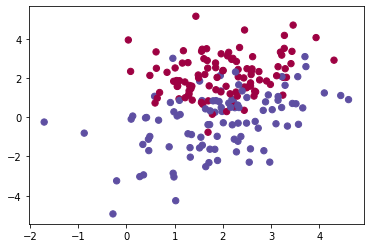

In [3]:
loader = PlanarDataset(200)

# Silakan coba-coba ganti parameternya
X, Y = loader.load_dataset('plain')
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

Perhatikan bahwa data seperti sudah terkelompokkan berdasarkan label, dengan beberapa data pencilan. Model yang akan dibangun harus bisa memisahkan kedua label data ini.

#### 1.3. Menyiapkan beberapa fungsi pendukung

Kita definisikan paling tidak dua fungsi berikut yang kelak akan kita pakai.
1. Fungsi untuk membuat "batas keputusan", yakni pemisah $\mathbb{R}^2$ menjadi 2 region saling lepas berdasarkan label.  

In [4]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

2. Fungsi untuk memetakan seluruh bilangan Riil ke rentang $[0,1]$, karena luaran akhir dari model kita harus berupa kelas label. Banyak fungsi yang dapat digunakan, tapi yang cukup sering dipakai, dengan beberapa kelebihannya, adalah fungsi sigmoid

In [5]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

###Jaringan Neural Dangkal

#### 3.1. Membangun model

Kita tidak akan langsung gunakan OOP. Agar mudah memahami dulu, kita bangun modelnya perlahan. Mula-mula, kita siapkan beberapa fungsi dasar.

##### 3.1.1. Inisialisasi parameter 

Kita definisikan fungsi untuk menginisialisasi parameter bobot $w$ dan parameter bias $b$. Kita gunakan pendekatan campuran di sini, yakni $w$ kita inisialisasi secara acak, sedangkan $b$ kita inisialisasi dengan nol.

In [6]:
def initialize_parameters(n_x, n_h, n_y):    
    # inisialisasi W secara acak dan b dengan 0
    w1 = np.random.rand(n_h, n_x)
    b1 = np.zeros((n_h, 1))
    w2 = np.random.rand(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    return w1, w2, b1, b2

##### 3.1.2. Propagasi

Selanjutnya, kita definisikan fungsi untuk propagasi perhitungannya. Kali ini, kita pisah jadi dua fungsi agar mudah untuk dibaca. Ingat bahwa propagasi maju adalah untuk mneghitung nilai luaran dari tiap neuron-nya, dan propagasi mundur adalah untuk menghitung gradient dari nilai $C$ terhadap tiap parameternya.

Dalam jaringan ini, kita gunakan aktivasi tangen hiperbolik pada lapisan tersembunyinya.

In [7]:
def forward_propagation(X, w1, w2, b1, b2):
    Z1 = np.dot(w1, X) + b1
    A1 = np.tanh(Z1) 
    Z2 = np.dot(w2, A1) + b2
    A2 = np.tanh(Z2)
        
    return A1, A2

Ingat kembali proses gradient descent-nya.

In [8]:
def backward_propagation(A1, A2, w2, X, Y):
    m = X.shape[1]

    dZ2 = A2 - Y
    dw2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis = 1, keepdims =True)/m
    dZ1 = np.dot(w2.T, dZ2)*(1. - np.power(A1, 2))
    dw1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis = 1, keepdims = True)/m
    
    return dw1, dw2, db1, db2

##### 3.1.3 Optimisasi

Tak lupa kita definisikan fungsi untuk update parameter di tiap iterasinya sebagai bagian dari proses optimisasi

In [9]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    w1, w2, b1, b2 = parameters
    dw1, dw2, db1, db2 = grads

    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
        
    return w1, w2, b1, b2

##### 3.1.4. Pelengkap

Sebelum kita definisikan modelnya, beberapa fungsi pelengkap lagi perlu didefinisikan. Perlu dipahami bahwa fungsi-fungsi di bawah ini bukan bagian dari proses learning itu sendiri, tapi hanya kebutuhan programmer untuk melacak proses.

In [10]:
def compute_cost(A2, Y):
    m = Y.shape[1] # number of example

    logprob = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = - np.sum(logprob)
    
    return float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 

In [11]:
def predict(parameters, X):    
    _, A2 = forward_propagation(X, *parameters)
    predictions = (A2 > 0.5)
    
    return predictions

In [12]:
def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    print("train accuracy: {} %".format(accuracy))

##### 3.1.5. Bungkus!



Barulah kemudian kita bisa bangun modelnya

In [13]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 1.2, print_cost=False):    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
        A1, A2 = forward_propagation(X, *parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(A1, A2, parameters[1], X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % (num_iterations // 10) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

#### 3.2. Melatih Model

Tentukan terlebih dahulu berapa neuron yang termuat dalam *hidden layer*. Ini menentukan kompleksitas hasil

In [14]:
hidden_neuron = 4

Kemudian kita masukkan semua yang dibutuhkan ke model yang tellah dibangun

In [15]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, hidden_neuron, 100000, 0.5, True)
get_accuracy(parameters, X, Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Cost after iteration 0: nan
Cost after iteration 10000: 62.299738
Cost after iteration 20000: 62.128358
Cost after iteration 30000: 60.133929
Cost after iteration 40000: 60.164272
Cost after iteration 50000: 60.334216
Cost after iteration 60000: 60.431991
Cost after iteration 70000: 60.464373
Cost after iteration 80000: 60.467408
Cost after iteration 90000: 60.463344
train accuracy: 87.5 %


Wah, akurasi yang didapatkan tidak signifikan. Pada beberapa kasus (bersifat acak tergantung inisiaisasi parameter awal), bahkan akurasinya bisa lebih buruk.
Coba kita lihat dulu pembagian region-nya

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

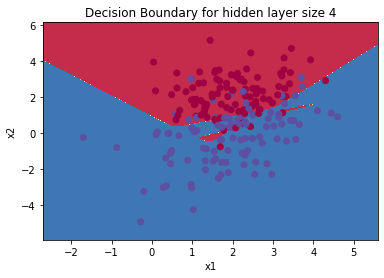

In [16]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(hidden_neuron))

Terlihat bahwa batas pembagi yang terbuat tidak lagi sesederhana garis lurus seperti pada regresi logistik. 

### Tugas

Lakukan analisis sensitivitas jumlah neuron pada setiap dataset selain yang plain. Plot *decision boundary* dari setiap hasil training. Juga, plot akurasi berbanding jumlah neuron pada setiap dataset.

Jelaskan hasil analisismu.

##Jawaban

In [17]:
def get_accuracy(parameters, X, Y):
    predictions = predict(parameters, X)
    correctly_predicted = np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T)
    accuracy = float(correctly_predicted)/float(Y.size)*100  
    return accuracy

Dibawah ini adalah code untuk menghasilkan plot decision boundary hasil training dari setiap dataset dengan jumlah neuron tertentu pada hidden layernya


Data: plain


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


Dengan 8 layer memiliki train accuracy: 87.0 %
Dengan 16 layer memiliki train accuracy: 87.0 %
Dengan 24 layer memiliki train accuracy: 87.0 %
Dengan 32 layer memiliki train accuracy: 87.0 %
Dengan 40 layer memiliki train accuracy: 87.0 %

Data: flower
Dengan 8 layer memiliki train accuracy: 86.5 %
Dengan 16 layer memiliki train accuracy: 84.0 %
Dengan 24 layer memiliki train accuracy: 86.5 %
Dengan 32 layer memiliki train accuracy: 86.0 %
Dengan 40 layer memiliki train accuracy: 85.0 %

Data: circles
Dengan 8 layer memiliki train accuracy: 76.5 %
Dengan 16 layer memiliki train accuracy: 73.5 %
Dengan 24 layer memiliki train accuracy: 76.5 %
Dengan 32 layer memiliki train accuracy: 75.0 %
Dengan 40 layer memiliki train accuracy: 70.5 %

Data: moons
Dengan 8 layer memiliki train accuracy: 93.0 %
Dengan 16 layer memiliki train accuracy: 91.5 %
Dengan 24 layer memiliki train accuracy: 87.0 %
Dengan 32 layer memiliki train accuracy: 90.0 %
Dengan 40 layer memiliki train accuracy: 92.0 %

D

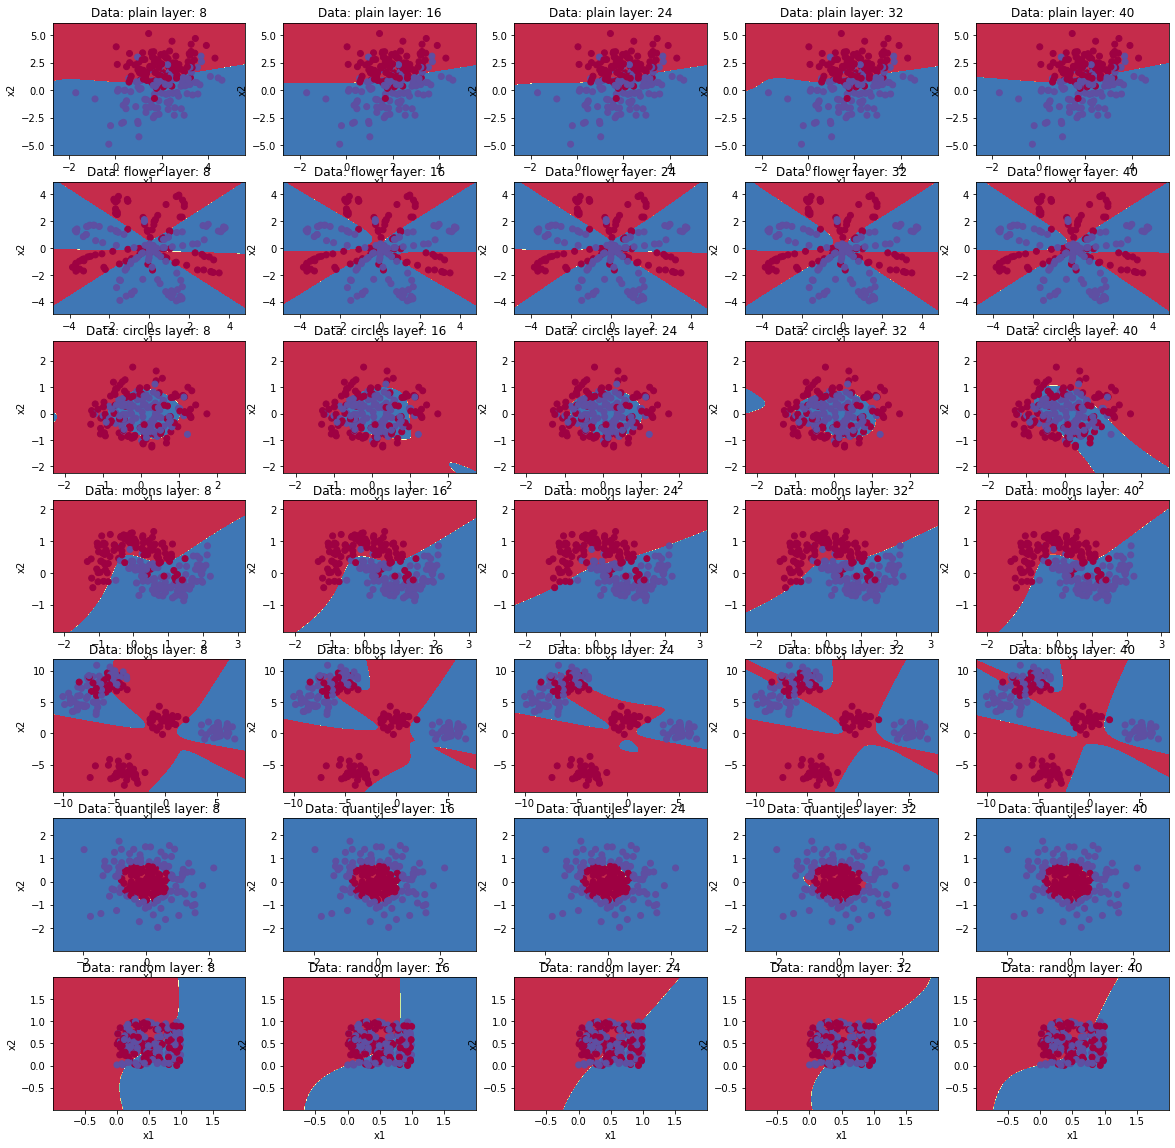

In [18]:
num_hidden = 40
plt.figure(figsize=(20, 20))

dataset_lst = [
    'plain', #0
    'flower', #1
    'circles', #2
    'moons', #3
    'blobs', #4
    'quantiles', #5 
    'random' #6
]

all_accuracy = []

for i, shape in enumerate(dataset_lst):
  print("\nData: " + shape)
  X, Y       = loader.load_dataset(shape)
  accuracy   = []  
  for h in range(1, num_hidden+1):
    parameters = nn_model(X, Y, 8, 2000, 0.05, False)
    accuracy.append(get_accuracy(parameters, X, Y))
    if h%(num_hidden//5) == 0:
      print("Dengan", h,"layer memiliki","train accuracy: {} %".format(accuracy[h-1]))
      plt.subplot(7, 5, int(h/(num_hidden//5)) + i*5)
      plt.title("Data: " + shape + " layer: "+ str(h))
      plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
  all_accuracy.append(accuracy)

Dibawah ini adalah code untuk menghasilkan grafik perubahan train accuracy terhadap banyaknya neuron pada hidden layer dari setiap data set

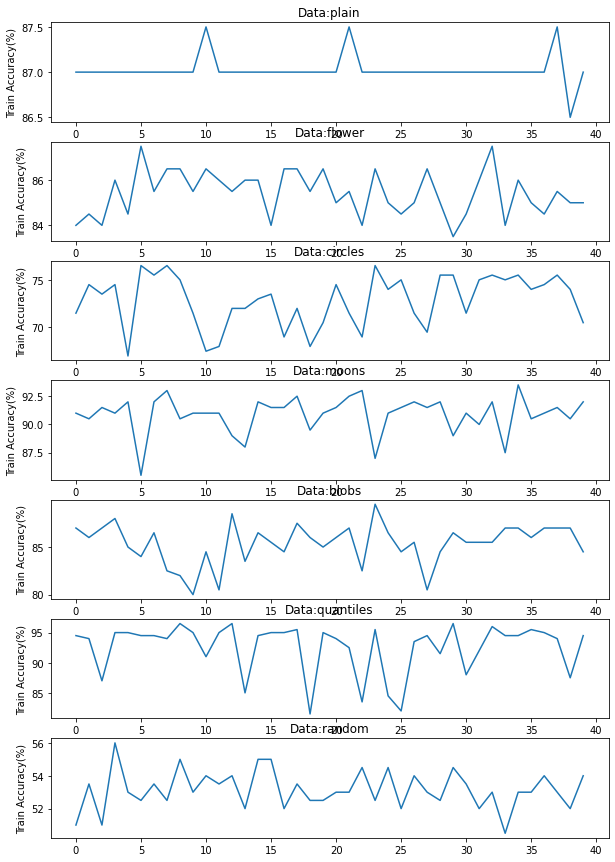

In [19]:
plt.figure(figsize=(10, 15))
for i, shape in enumerate(dataset_lst):
  plt.subplot(7, 1, i+1)
  plt.plot(all_accuracy[i])
  plt.ylabel("Train Accuracy(%)")
  plt.title("Data:" + shape)

####Kesimpulan

1. Jika kita lihat pada plot decision boundarynya, masing-masing data set memiliki akurasi yang bervariasi dengan train accuracy paling kecil dimiliki oleh data set random, sedangkan untuk train accuracy paling besar dimiliki oleh data set quantiles dan moons. Ini mengartikan, ketika ketika kita ingin membuat suatu model deep learning, kita perlu mengetahui bagaimana karakteristik data yang ingin kita olah. Bisa jadi, data yang ingin kita olah sama sekali tidak cocok dengan model yang digunakan sehingga dengan berapapun jumlah neuron pada hidden layernya, hasilnya akan selalu buruk, dan begitu pula sebaliknya.

2. Selain itu, jika dilihat pada grafik train accuracy terhadap jumlah neuron pada hidden layer untuk setiap data set, terlihat bahwa akurasi untuk setiap data set tidak semakin membaik dengan bertambahnya jumlah neuron yang lebih banyak. Maka dari itu, ketika kita ingin membuat model deep learning, kita perlu dapat mencari jumlah neuron terbaik pada hidden layer agar dapat memberikan akurasi paling maksimal